Notebook done by Jeremy

# Imports

In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import statsmodels as st
import statsmodels.api as sm
from scipy import stats
from pandas import DataFrame
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from dateutil.parser import parse
import scipy.stats as scs
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

#Stop warnings
import warnings
warnings.filterwarnings("ignore")


# Read Data

In [2]:
def read_CLEAN_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Convert datetimes
    dat["Date"] = pd.to_datetime(dat["Date"], format = '%Y-%m-%d').dt.date
    
    return dat
# 10 hours of non zeroes 
def ten_hours_non_zeros(df,hours):
    df1 = df.copy()
    df1['Not Zero'] = df1['Steps'] > 0
    df1 = df1.groupby('Date').sum()
    df1 = df1['Not Zero'] > hours 
    return df1
#Greater than 500 steps
def greater_than_certain_steps(df,min_steps):
    df1 = df.copy()
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps']> min_steps
    return df1


#Active in 3 time blocks 
def three_time_blocks(df):
    df1 = df.copy()
    bins = [-1,2,10,14,25,np.inf]
    names = ['3','1','2', '4', '5']
    df1['3timeblock'] = pd.cut(df1['Hour'],bins, labels = names)
    df1 = df1.replace({'3timeblock':r'4'},{'3timeblock':'3'},regex = True)
    df1 = df1.replace({'3timeblock':r'5'},{'3timeblock':'3'},regex = True)
    df1 = df1.groupby(['Date','3timeblock'], as_index=False)['Steps'].sum()
    df1['Steps within timeblock'] = df1['Steps']> 0 
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps within timeblock'] ==3 
    return df1

#Combining it all into 1 dataframe
def three_method_table(x):
    valid_1= ten_hours_non_zeros(x,10)
    valid_2= greater_than_certain_steps(x,500)
    valid_3= three_time_blocks(x)
    result = pd.concat([valid_1,valid_2,valid_3], axis=1, join='inner')
    result.reset_index(level=0, inplace=True)
    result.columns = ["Date", "Ten Hours Non Zero","Steps > Five Hundred","Three Timeblock"]
    result['All Three True'] = result["Three Timeblock"]*result["Ten Hours Non Zero"]*result["Steps > Five Hundred"]
    result_sum = result.sum()
    return result , result_sum

def filter_by_adherence(df, measure):
    df2 = three_method_table(df)[0]
    df3 = df.merge(df2,on ='Date')
    if(measure == 1):
        mask = (df3['Ten Hours Non Zero'] == True)
    elif(measure == 2):
        mask = (df3['Steps > Five Hundred'] == True)
    elif(measure == 3):
        mask = (df3['Three Timeblock'] == True)    
    elif(measure == 4):
        mask = (df3['All Three True'] == True)
    filtered_df = df3.loc[mask].drop(['Ten Hours Non Zero', 'Steps > Five Hundred', 'Three Timeblock', 'All Three True'], axis=1)

    return filtered_df

# Method 1 calculates daily steps based on all the step activity that is available during the day
def all_step_activity(df):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 2 calculates daily steps based on the 10 most active hours of the day
def top_ten_most_active_hours(df):
    
    df = df.sort_values(by=["Date", "Steps"], ascending=False).groupby('Date').head(10)
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 3 calculates daily steps based on a 10 hour time block during the day
def ten_hour_time_block(df, start_hour, end_hour):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    mask = (df['Hour'] >= start_hour) & (df['Hour'] <= end_hour)
    df = df.loc[mask]
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

def calculate_daily_steps(file_name, filter_measure, start_time, end_time):
    
    df = read_CLEAN_data(filename)
    filtered_df = filter_by_adherence(df, filter_measure)
    
    dailysteps_method2 = top_ten_most_active_hours(filtered_df)
    dailysteps_method1 = all_step_activity(filtered_df)
    dailysteps_method3 = ten_hour_time_block(filtered_df, start_time, end_time)
    
   
    return dailysteps_method1,dailysteps_method2,dailysteps_method3
   
    

In [3]:
filename = "../../../data/cleaned/Participant3.csv"

filter_measure = 3
start_time = 8
end_time = 18

ds_method1, ds_method2, ds_method3 = calculate_daily_steps(filename, filter_measure, start_time, end_time)


In [27]:
ds_method1.set_index('Date',inplace=True)
ds_method1.shape

(865, 1)

# Method 1

# Steps to take to implement (S)ARIMA

1) Check for Seasonality <br />
2) Check for Stationarity <br />
3) If not Stationary perform Rolling/ Smoothing/ Shifting/ Differentiation <br />
4) Obtain SARIMA Parameters <br />
5) Data Splitting and Model evaluation by plots <br />
6) Data Forecasting


### 1) Check For Seasonality

##### Simple Plot

In [28]:
ds_method1.shape

(865, 1)

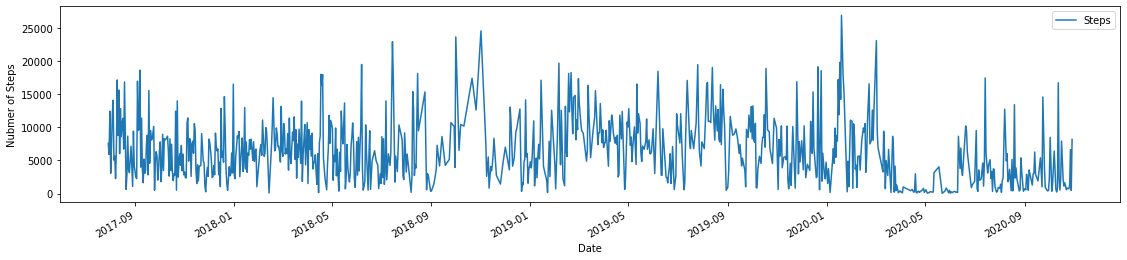

In [29]:
ds_method1.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

#### Seasonal Decompose Plot

Using the command, we can decompose the time series into three distinct components: Trend, Seasonality and noise

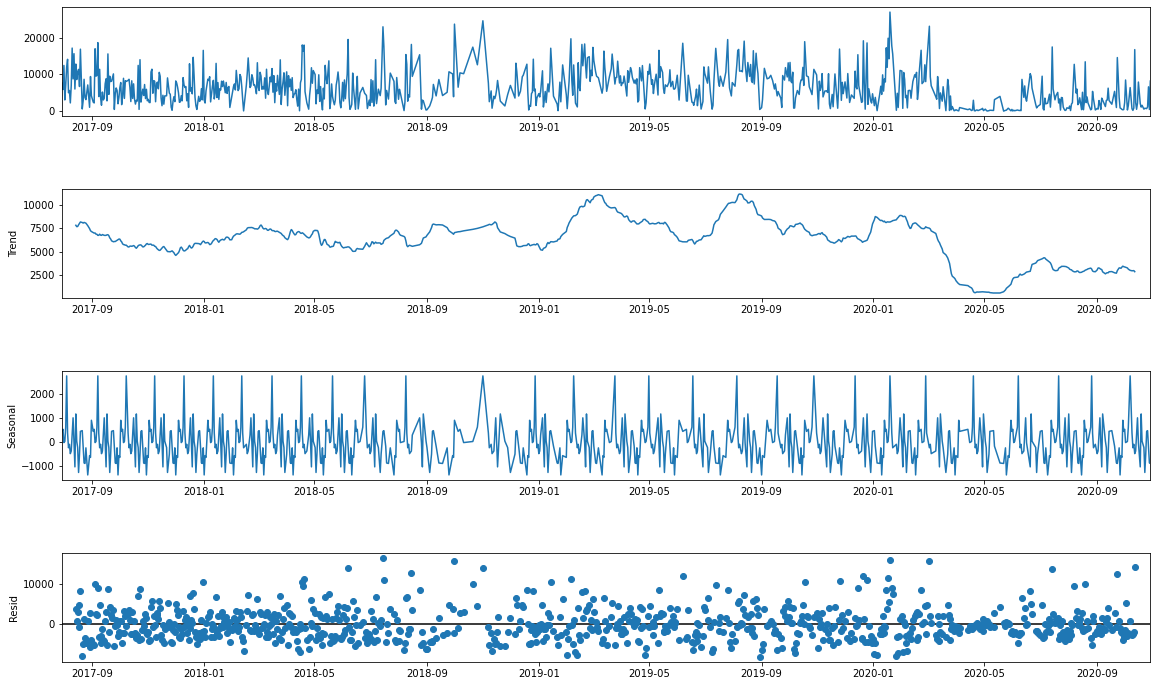

In [30]:
decomposition = sm.tsa.seasonal_decompose(ds_method1, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

After adherence, it appears that the data does have some form of Seasonality over the years besides certain year-gaps. As such, we will employ the SARIMA here instead of ARMIA

# Check for data Stationarity

Will use this function to test for stationarity by using the **Augmented Dickey-Fuller test**

where <br />
$H_0$: If failed to be rejected, time series data is not stationary <br />
$H_1$: If $H_0$ is rejected, it means the time series data is stationary

In [31]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Number of Steps")
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Perform Dickeyâ€“Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Steps'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

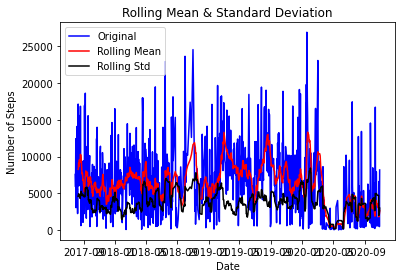

Results of Dickey Fuller Test:
ADF Test Statistic            -7.152084e+00
p-value                        3.122180e-10
#Lags Used                     5.000000e+00
Number of Observations Used    8.590000e+02
Critical Value (1%)           -3.437986e+00
Critical Value (5%)           -2.864911e+00
Critical Value (10%)          -2.568565e+00
dtype: float64


In [32]:
test_stationarity(ds_method1)

For this, we will use the $\alpha$ value of 0.05 to check against the p-value of 3.122180e-10 to decide if we will accept or reject the $H_0$. As $\alpha$ > p-value, we can conclude that the data is stationary.

## Making Data Stationary

As the data is stationary, we do not need to perform any transformation of the data to achieve stationarity.

### Data Transformation to acheive Normality

#### Log Transformation

In [10]:
#Estimating trend
#ds_method1 = np.log(ds_method1)
#plt.plot(ds_method1)

# (S)ARIMA Parameters

#### ACF and PACF plots

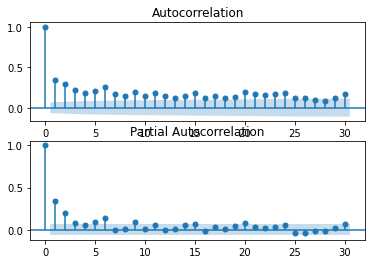

In [33]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method1, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method1, ax=ax[1])
plt.show()

### Parameter Selection

In [34]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method1, start_p=0, start_q=0,
                           max_p=6, max_q=6, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, max_P = 10, max_Q = 10, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=17068.442, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=16959.872, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=16993.538, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=17963.022, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=16960.817, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=16953.601, Time=1.42 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=16954.962, Time=3.27 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=16952.855, Time=1.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=16961.754, Time=0.52 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=16950.479, Time=1.95 sec
 ARIMA(1,0,0)(4,0,1)[12] intercept   : AIC=16952.015, Time=5.29 sec
 ARIMA(1,0,0)(3,0,2)[12] intercept   : AIC=inf, Time=5.62 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=16954.478, Time=1.51 sec
 ARIMA(1,0,0)(4,0,0)[12] intercept   : AIC=16956.640, Time=5.30 sec
 ARIMA(1,0,

So, the best set of paramters to select is  **ARIMA(6,0,0)(2,0,0)[12]** I selected m = 12 to represent the yearly number of months each 'season' runs for 

In [35]:
model = sm.tsa.statespace.SARIMAX(ds_method1, order=(6,0,0), seasonal_order = (2,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, ax=ax[1])
plt.show()

Optimization terminated successfully.
         Current function value: 9.783146
         Iterations: 3
         Function evaluations: 315


In [19]:
train = ds_method1.loc['2017-08-01':'2020-01-03']
test = ds_method1.loc['2020-01-08':]
stepwise_model.fit(train)

ARIMA(order=(6, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [36]:
mod = sm.tsa.statespace.SARIMAX(ds_method1,
                                order=(6, 0, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                  865
Model:               SARIMAX(6, 0, 0)   Log Likelihood               -8404.769
Date:                Tue, 17 Nov 2020   AIC                          16823.539
Time:                        17:14:51   BIC                          16856.829
Sample:                             0   HQIC                         16836.284
                                - 865                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2922      0.033      8.802      0.000       0.227       0.357
ar.L2          0.2045      0.032      6.442      0.000       0.142       0.267
ar.L3          0.0831      0.032      2.618      0.0

### Some Plots

In [37]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

### (S)ARIMA Model Validation

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 

Train Set 80%, Validation 20%

In [39]:
# the 20% point test data is on the specified date below
split_date = '2020-01-03'
data = ds_method1['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(6, 0, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [40]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae1 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse1 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse1 = math.sqrt(mse1)
print(f'Mean Squared Error: {mse1.round(4)}')
print(f'Root Mean Squared Error: {round(rmse1,4)}')
print(f'Mean Absolute Error: {mae1.round(4)}')

Mean Squared Error: 30031904.6077
Root Mean Squared Error: 5480.1373
Mean Absolute Error: 3478.8211


### Model Prediction

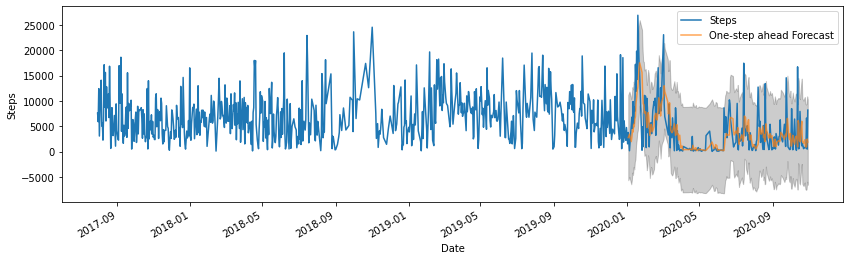

In [41]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-03'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method1['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

# Method 2

In [42]:
#method_1.set_index('Date',inplace=True)
ds_method2.set_index('Date',inplace=True)
ds_method2.head()

Steps
Date                    
2017-07-30   7582.427320
2017-07-31   5903.087652
2017-08-01  12335.158512
2017-08-02   3063.008540
2017-08-03   7027.358587

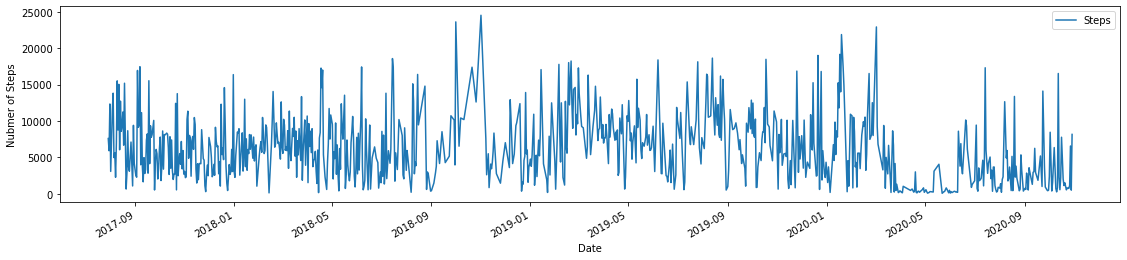

In [43]:
ds_method2.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

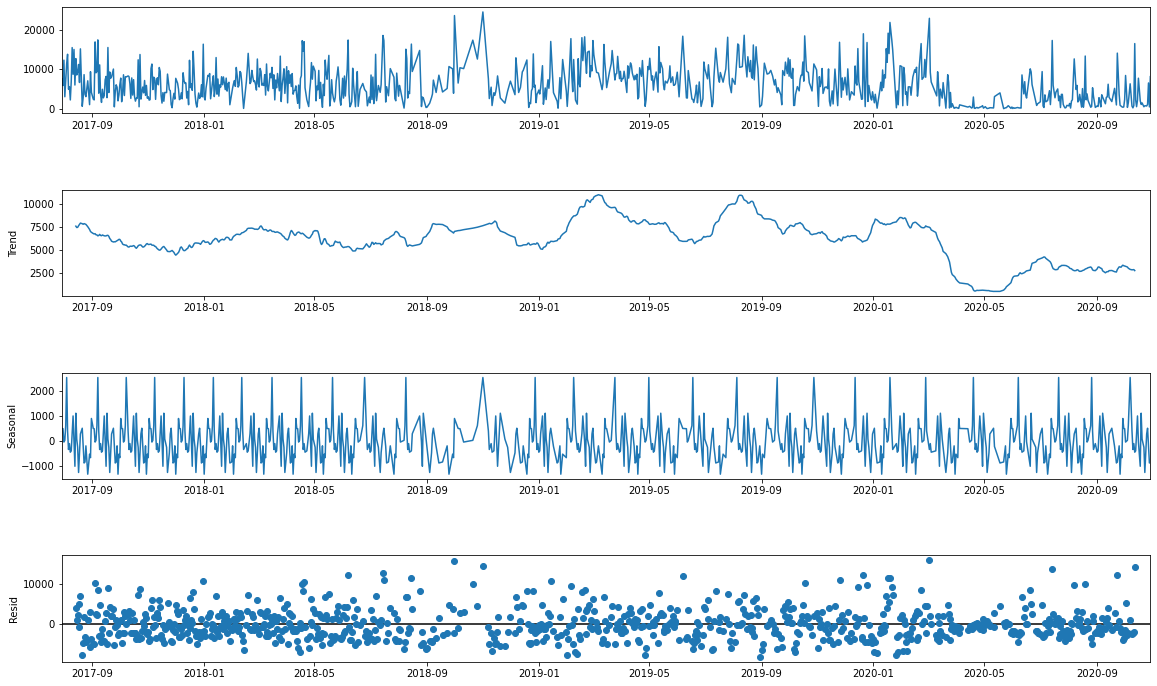

In [44]:
decomposition = sm.tsa.seasonal_decompose(ds_method2, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

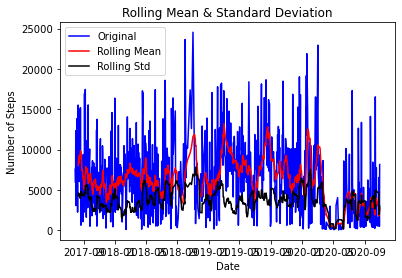

Results of Dickey Fuller Test:
ADF Test Statistic            -5.841748e+00
p-value                        3.763307e-07
#Lags Used                     8.000000e+00
Number of Observations Used    8.560000e+02
Critical Value (1%)           -3.438012e+00
Critical Value (5%)           -2.864922e+00
Critical Value (10%)          -2.568571e+00
dtype: float64


In [45]:
test_stationarity(ds_method2)

Again, data appears to be stationary so no transformation of the data was required. However, the data was not normal based on William's Observation. To normalise it, we logged the values

In [46]:
#Estimating trend
#ds_method2 = np.log(ds_method2)
#plt.plot(ds_method2)

### PACF and ACF plots

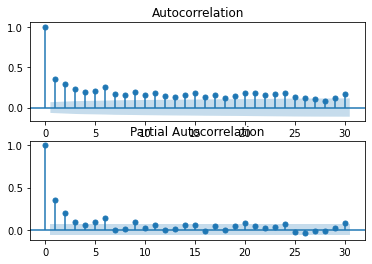

In [47]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method2, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method2,ax=ax[1])
plt.show()

### Parameter Selection

In [48]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method2, start_p=0, start_q=0,
                           max_p=6, max_q=6, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=17012.804, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=16901.276, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=16935.611, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=17920.463, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=16902.366, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=16894.319, Time=1.39 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=16893.404, Time=1.05 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=16903.169, Time=0.65 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=16894.964, Time=1.65 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=16892.992, Time=1.22 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=16892.092, Time=0.33 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=16901.573, Time=0.12 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=16979.830, Time=0.25 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=16863.301, Time=0.42 sec
 ARIM

Optimization terminated successfully.
         Current function value: 9.750481
         Iterations: 1
         Function evaluations: 84


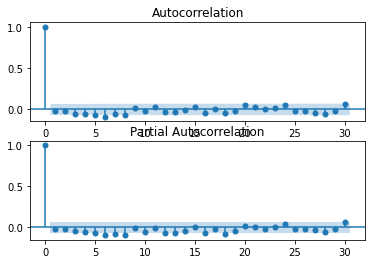

In [49]:
model = sm.tsa.statespace.SARIMAX(ds_method2, order=(6,0,0), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res,  ax=ax[1])
plt.show()

In [50]:
train = ds_method2.loc['2017-08-01':'2020-01-03']
test = ds_method2.loc['2020-01-08':]
stepwise_model.fit(train)

ARIMA(order=(6, 0, 0), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True)

In [51]:
mod = sm.tsa.statespace.SARIMAX(ds_method2,
                                order=(6,0,0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                  865
Model:               SARIMAX(6, 0, 0)   Log Likelihood               -8374.692
Date:                Tue, 17 Nov 2020   AIC                          16763.384
Time:                        17:17:01   BIC                          16796.674
Sample:                             0   HQIC                         16776.130
                                - 865                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2929      0.033      8.838      0.000       0.228       0.358
ar.L2          0.1992      0.032      6.196      0.000       0.136       0.262
ar.L3          0.0891      0.033      2.723      0.0

### Some Plots

In [52]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

### Model Validation

In [53]:
# the 20% point test data is on the specified date below
split_date = '2020-01-03'
data = ds_method2['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(6,0, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [54]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae2 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse2 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse2 = math.sqrt(mse2)
print(f'Mean Squared Error: {mse2.round(4)}')
print(f'Root Mean Squared Error: {round(rmse2,4)}')
print(f'Mean Absolute Error: {mae2.round(4)}')

Mean Squared Error: 28165508.5488
Root Mean Squared Error: 5307.1187
Mean Absolute Error: 3403.6747


### Model Prediction

In [55]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-03'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method2['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()
plt.show()

# Method 3

In [56]:
#method_1.set_index('Date',inplace=True)
ds_method3.set_index('Date',inplace=True)

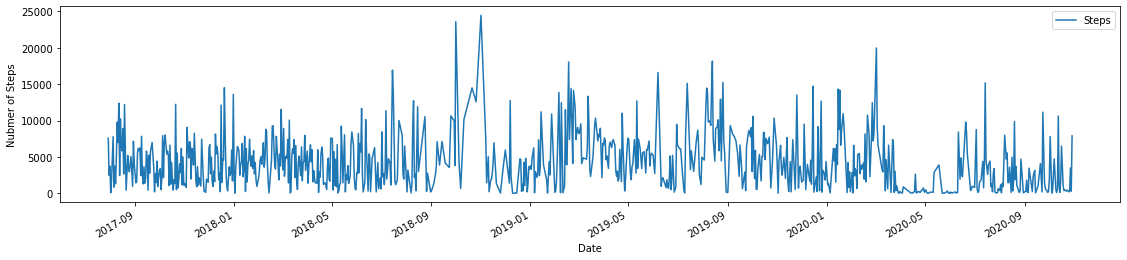

In [57]:
ds_method3.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

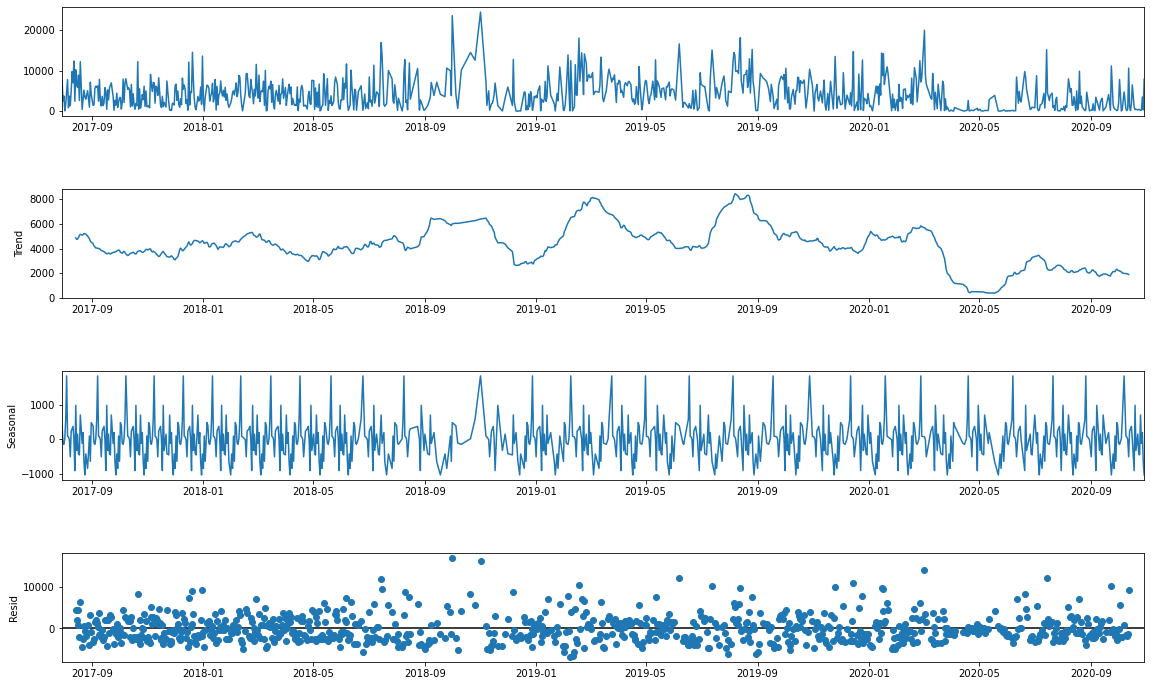

In [58]:
decomposition = sm.tsa.seasonal_decompose(ds_method3, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

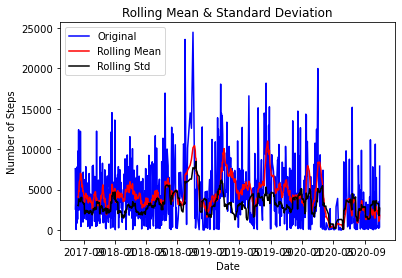

Results of Dickey Fuller Test:
ADF Test Statistic            -7.116871e+00
p-value                        3.810781e-10
#Lags Used                     5.000000e+00
Number of Observations Used    8.590000e+02
Critical Value (1%)           -3.437986e+00
Critical Value (5%)           -2.864911e+00
Critical Value (10%)          -2.568565e+00
dtype: float64


In [59]:
test_stationarity(ds_method3)

In [60]:
#Estimating trend
#ds_method3 = np.log(ds_method3)
#plt.plot(ds_method3)

### ACF and PACF plots

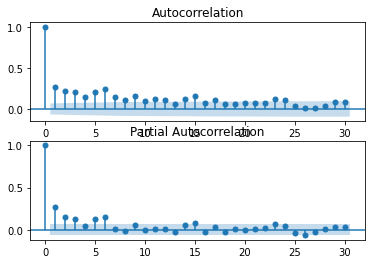

In [61]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method3,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method3,  ax=ax[1])
plt.show()

### Parameter Selection

In [67]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method3, start_p=0, start_q=0,
                           max_p=6, max_q=10, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=16676.037, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=16608.861, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=16624.364, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=17389.724, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=16611.565, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=16608.422, Time=0.79 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=16607.778, Time=1.23 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=16609.762, Time=1.69 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=16607.818, Time=1.06 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=16664.792, Time=0.90 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=16590.740, Time=1.29 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=16593.610, Time=0.77 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=16589.713, Time=1.19 sec
 ARIMA(2,0,

Optimization terminated successfully.
         Current function value: 9.629377
         Iterations: 4
         Function evaluations: 284


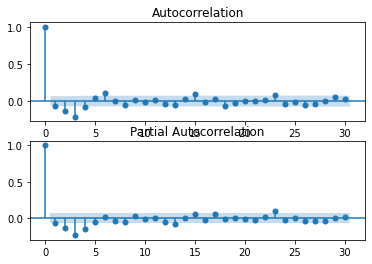

In [78]:
model = sm.tsa.statespace.SARIMAX(ds_method3, order=(3,0,0), seasonal_order = (2,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

In [79]:
train = ds_method3.loc['2017-08-01':'2020-01-03']
test = ds_method3.loc['2020-01-08':]
stepwise_model.fit(train)

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

In [80]:
mod = sm.tsa.statespace.SARIMAX(ds_method3,
                                order=(3,0,0),
                                seasonal_order=(2, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Steps   No. Observations:                  865
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 12)   Log Likelihood               -8067.965
Date:                            Tue, 17 Nov 2020   AIC                          16147.931
Time:                                    17:30:30   BIC                          16176.317
Sample:                                         0   HQIC                         16158.811
                                            - 865                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3330      0.030     11.034      0.000       0.274       0.392
ar.L2          0.2285      0.031   

### Some Plots

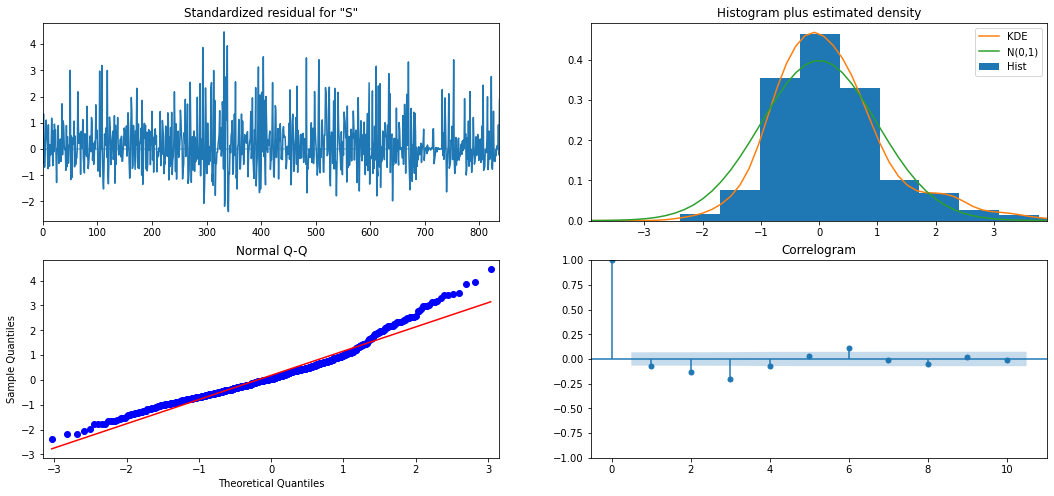

In [81]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

### Model Validation

In [82]:
# the 20% point test data is on the specified date below
split_date = '2020-01-03'
data = ds_method3['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(3,0,0),
                                seasonal_order=(2, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [83]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae3 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse3 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse3 = math.sqrt(mse3)
print(f'Mean Squared Error: {mse3.round(4)}')
print(f'Root Mean Squared Error: {round(rmse3,4)}')
print(f'Mean Absolute Error: {mae3.round(4)}')

Mean Squared Error: 18916486.9079
Root Mean Squared Error: 4349.3088
Mean Absolute Error: 2713.1195


### Prediction

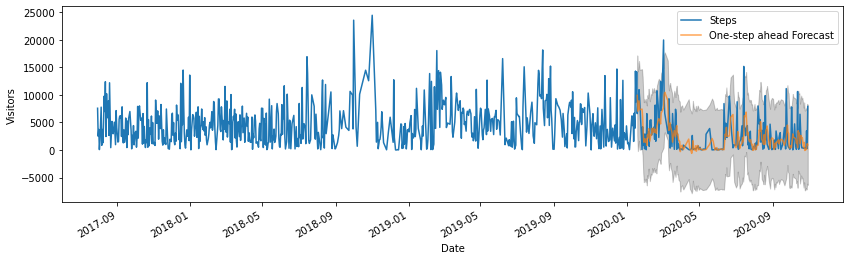

In [84]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-18'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method3['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()
plt.show()

In [85]:
models = pd.DataFrame({
    'Method': ['Method 1', 'Method 2', 'Method 3'],
    'MSE': [round(mse1, 4), round(mse2, 4), round(mse3,4)],
    'RMSE': [round(rmse1,4 ), round(rmse2, 4), round(rmse3,4)],
    'MAE': [round(mae1, 4), round(mae2, 4), round(mae3,4)]})
models

Method           MSE       RMSE        MAE
0  Method 1  3.003190e+07  5480.1373  3478.8211
1  Method 2  2.816551e+07  5307.1187  3403.6747
2  Method 3  1.891649e+07  4349.3088  2713.1195

Overall, it appears that the Method 3 performs the best in terms of both prediction and RMSE values.